# Weather and Energy Usage Correlation Report

This notebook analyzes the correlation between weather (temperature) and energy/gas usage, focusing on daily aggregates to identify patterns (e.g., higher gas usage on colder days).

In [1]:
# Import libraries
import pandas as pd
import matplotlib.pyplot as plt
from home_messages_db import HomeMessagesDB

# Connect to database
db = HomeMessagesDB('sqlite:///smarthome.db')

# Fetch data
weather_data = db.query_weather()
electricity_data = db.query_electricity()
gas_data = db.query_gas()

# Convert to DataFrames
weather_df = pd.DataFrame([(w.epoch, w.temperature) for w in weather_data],
                         columns=['epoch', 'temperature'])
electricity_df = pd.DataFrame([(e.epoch, e.t1_kwh, e.t2_kwh) for e in electricity_data],
                             columns=['epoch', 't1_kwh', 't2_kwh']).sort_values('epoch')
gas_df = pd.DataFrame([(g.epoch, g.gas_m3) for g in gas_data],
                     columns=['epoch', 'gas_m3']).sort_values('epoch')

# Calculate differences for usage
electricity_df['t1_kwh_diff'] = electricity_df['t1_kwh'].diff().fillna(0)
electricity_df['t2_kwh_diff'] = electricity_df['t2_kwh'].diff().fillna(0)
gas_df['gas_m3_diff'] = gas_df['gas_m3'].diff().fillna(0)

# Filter out negative differences
electricity_df = electricity_df[(electricity_df['t1_kwh_diff'] >= 0) & (electricity_df['t2_kwh_diff'] >= 0)]
gas_df = gas_df[gas_df['gas_m3_diff'] >= 0]

# Convert epoch to date (for daily aggregation)
weather_df['date'] = pd.to_datetime(weather_df['epoch'], unit='s', utc=True).dt.date
electricity_df['date'] = pd.to_datetime(electricity_df['epoch'], unit='s', utc=True).dt.date
gas_df['date'] = pd.to_datetime(gas_df['epoch'], unit='s', utc=True).dt.date

# Aggregate by day
daily_weather = weather_df.groupby('date').agg({'temperature': 'mean'}).reset_index()
daily_electricity = electricity_df.groupby('date').agg({'t1_kwh_diff': 'sum', 't2_kwh_diff': 'sum'}).reset_index()
daily_gas = gas_df.groupby('date').agg({'gas_m3_diff': 'sum'}).reset_index()

# Merge data
daily_data = pd.merge(daily_weather, daily_electricity, on='date', how='inner')
daily_data = pd.merge(daily_data, daily_gas, on='date', how='inner')

# Close database connection
db.close()

# Display the first few rows
daily_data.head()

,date,temperature,t1_kwh_diff,t2_kwh_diff,gas_m3_diff
0,2022-06-01,11.783333,3.556,10.711,0.681
1,2022-06-02,13.670833,3.666,6.477,0.392
2,2022-06-03,15.958333,4.204,9.285,1.363
3,2022-06-04,15.070833,13.694,0.000,1.387
4,2022-06-05,15.654167,12.225,0.000,0.582


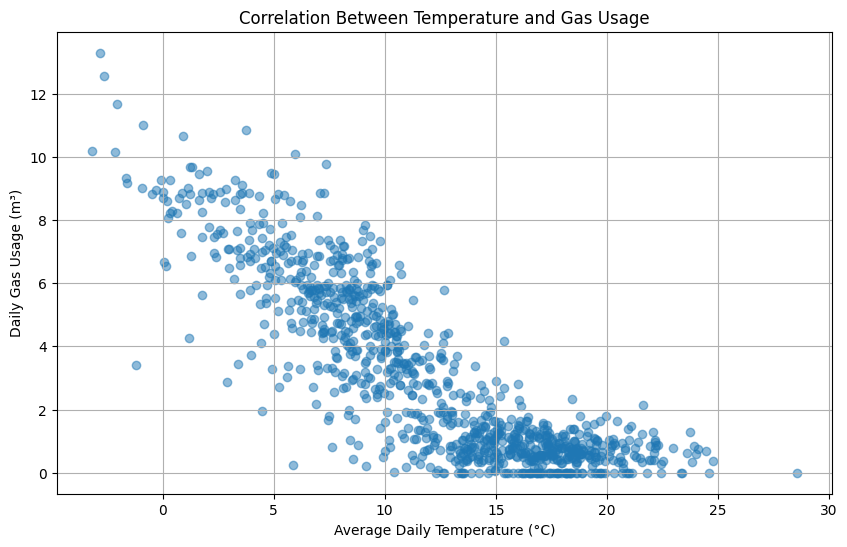

Correlation coefficient between temperature and gas usage: -0.86


In [2]:
# Plot temperature vs. gas usage
plt.figure(figsize=(10, 6))
plt.scatter(daily_data['temperature'], daily_data['gas_m3_diff'], alpha=0.5)
plt.xlabel('Average Daily Temperature (°C)')
plt.ylabel('Daily Gas Usage (m³)')
plt.title('Correlation Between Temperature and Gas Usage')
plt.grid(True)

# Save the plot
plt.savefig('temperature_gas_correlation.png')
plt.show()

# Calculate correlation coefficient
correlation = daily_data['temperature'].corr(daily_data['gas_m3_diff'])
print(f'Correlation coefficient between temperature and gas usage: {correlation:.2f}')

## Analysis
- **Correlation**:
 The correlation coefficient between temperature and gas usage is -0.86. This means there’s a strong negative relationship. As the temperature goes down, gas usage goes up, probably because people use more gas for heating when it’s colder.
 
- **Patterns**:
 The scatter plot shows that when the average daily temperature is lower (like below 5°C), the gas usage is higher. This makes sense because colder days need more heating. As the temperature gets warmer (above 15°C), the gas usage drops a lot, showing that heating is used less.
